# Distance Estimation and Angle Recovery

TODO: put equateions

## Content

1. [Data Preparation](Read-Data)
2. 

## Read Data

Data used:
- Protein: 5j0n (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5j0n.pdb1-500.jpg)

In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import h5py
import numpy as np
import time

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv

In [3]:
tf.__version__

'2.1.0'

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15157313410856722495
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6973260326682814370
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1323257161239249471
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16216559989543714648
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 4987929926787026536
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:3b:00.0, compute capability: 3.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory

In [5]:
PROTEIN="5j0n"#"5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [6]:
# location of *.h5 files
#data_dir = f"{ROOT_DIR}/data"
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [7]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [8]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [9]:
# plot_angles_count(angles_true)

---

## Prepare for training

In [10]:
from sklearn.model_selection import train_test_split
from cryoem.distance_estimation import create_pairs

In [11]:
X, y = np.array(data['Projections'], dtype=np.float32), np.array(data['Angles'], dtype=np.float32)

In [12]:
X_max_px = np.max(X)
X = X/X_max_px
print(f"Projection images will be normalized to have pixels ranging from 0 to 1 instead of 1 to {X_max_px}")

Projection images will be normalized to have pixels ranging from 0 to 1 instead of 1 to 15.440114974975586


In [13]:
# the data, split between train and test sets
train_idx, test_idx = train_test_split(range(NUM_PROJECTIONS), 
                                       test_size=0.33, 
                                       random_state=42)
train_idx, val_idx= train_test_split(train_idx, 
                                     test_size=0.25, 
                                     random_state=1)

train_idx = sorted(train_idx)
val_idx = sorted(val_idx)
test_idx = sorted(test_idx)

np.savez("data/5j0n/5j0n_siamese_idx", train_idx, val_idx, test_idx)

In [14]:
# TRAIN: 0.67 * 0.75 = 0.5025 => 2512 imgs => max pairs: 6 311 400
# TEST:  0.33                 => 1650 imgs => max pairs: 2 722 500
# VAL:   0.67*0.25 = 0.1675   =>  837 imgs => max pairs:   700 569

In [15]:
np.save("data/5j0n/test_idx", test_idx)

In [16]:
data = np.load("data/5j0n/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

In [17]:
# from scipy.spatial.transform import Rotation as R

# def sample_pairs(projection_idx, num_pairs, style="random", k=None):
#     if not k and style != "random":
#         raise ValueError("Please specify k for kNN for sample_pairs method")
    
#     if style=="random":
#         idx1 = list(np.random.choice(projection_idx, size=num_pairs))
#         idx2 = list(np.random.choice(projection_idx, size=num_pairs))
        
#     return idx1, idx2

# def create_pairs(x, y, indices, num_pairs):
#     '''Positive and negative pair creation.
#     Alternates between positive and negative pairs.
#     '''
# #     pairs = []
# #     labels = []

# #     # Sample some pairs.
# #     idx1, idx2 = sample_pairs(projection_idx=indices, num_pairs=num_pairs, style="random")

# #     for z1, z2 in zip(idx1, idx2):
# #         pairs += [[x[z1], x[z2]]]
# #         q1 = R.from_euler('zyz', y[z1]).as_quat()
# #         q2 = R.from_euler('zyz', y[z2]).as_quat()
# #         labels += [d_q(q1, q2)]

# #     pairs = np.array(pairs)
# #     print(pairs.shape)
# #     return np.array(pairs[:, 0, :, :])[:, np.newaxis, :, :], np.array(pairs[:, 1,:,:])[], np.array(labels)
#     pairs = []
#     labels = []
    
#     # Sample some pairs.
#     idx1, idx2 = sample_pairs(projection_idx=indices, num_pairs=num_pairs, style="random")
    
#     for z1, z2 in zip(idx1, idx2):
#         pairs += [[x[z1], x[z2]]]
#         labels += [d_q(euler2quaternion(y[z1]), euler2quaternion(y[z2]))]

#     pairs = np.array(pairs)
#     print(pairs.shape)
#     pairs = pairs.reshape(num_pairs, x.shape[1], x.shape[2], -1)
#     print(pairs.shape)
#     return pairs[:, :, :, 0][:,:,:, np.newaxis], pairs[:, :, :, 1][:,:,:,np.newaxis], np.array(labels)

In [18]:
# tr_data = tf.data.Dataset.from_tensor_slices(create_pairs(X, y, indices=train_idx, num_pairs=300))

In [19]:
# list(tr_data.take(1))[0]

In [20]:
# val_data = tf.data.Dataset.from_tensor_slices(create_pairs(X, y, indices=val_idx, num_pairs=20))
# te_data = tf.data.Dataset.from_tensor_slices(create_pairs(X, y, indices=test_idx, num_pairs=20))

In [21]:
# np.arange(18).reshape((2, 3, 3))

In [22]:
# np.arange(18).reshape((3, 3, 2))

In [23]:
# np.array(list(tr_data.as_numpy_iterator()))[0][0].shape

In [24]:
# tr_data.shard

In [25]:
# np.array(list(tr_data.as_numpy_iterator())).shape

In [26]:
# np.array(list(tr_data.as_numpy_iterator()))[:, :]

In [27]:
# # TODO: increase these values, it is just important to have the batches small enough
# start_time = time.time()

# tr_pairs, tr_y = create_pairs(X, y, indices=train_idx, num_pairs=300000)
# tr_pairs = tr_pairs.reshape(list(tr_pairs.shape) + [-1])
# tr_y = tf.cast(tr_y, dtype=tf.float32)

# val_pairs, val_y = create_pairs(X, y, indices=val_idx, num_pairs=20000)
# val_pairs = val_pairs.reshape(list(val_pairs.shape) + [-1])
# val_y = tf.cast(val_y, dtype=tf.float32)

# te_pairs, te_y = create_pairs(X, y, indices=test_idx, num_pairs=20000)
# te_pairs = te_pairs.reshape(list(te_pairs.shape) + [-1])
# te_y = tf.cast(te_y, dtype=tf.float32)

# print(f"{time.time()-start_time:.0f}s")

# 1. Distance Estimation

### Train the model

In [29]:
from time import time

In [30]:
start_time = time()

training_pairs, training_y = create_pairs(X, y, indices=train_idx, num_pairs=150000)
training_pairs = training_pairs.reshape(list(training_pairs.shape) + [-1])
training_y = tf.cast(training_y, dtype=tf.float32)

validation_pairs, validation_y = create_pairs(X, y, indices=val_idx, num_pairs=20000)
validation_pairs = validation_pairs.reshape(list(validation_pairs.shape) + [-1])
validation_y = tf.cast(validation_y, dtype=tf.float32)

#         te_pairs, te_y = create_pairs(X, y, indices=test_idx, num_pairs=20000)
#         te_pairs = te_pairs.reshape(list(te_pairs.shape) + [-1])
#         te_y = tf.cast(te_y, dtype=tf.float32)

print(f"Data created in: {time()-start_time:.0f}s")

Data created in: 1858s


In [33]:
import os
import h5py
from time import time, strftime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pathlib

from cryoem.projections import RotationMatrix
from cryoem.conversions import euler2quaternion, d_q
from cryoem.knn import get_knn_projections

import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda, ZeroPadding2D, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model, multi_gpu_model





def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def mae(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true))

def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))




def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_x = Input(shape=input_shape)
    #print(input_shape)

    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    x = ZeroPadding2D([1, 1])(input_x)
    x = Conv2D(filters=32, kernel_size=[3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = ZeroPadding2D([1, 1])(x)
    x = Conv2D(filters=32, kernel_size=[3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], strides=[2, 2])(x)

    x = ZeroPadding2D([1, 1])(x)
    x = Conv2D(64, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = ZeroPadding2D([1, 1])(x)
    x = Conv2D(64, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], strides=[2, 2])(x)
    
    x = ZeroPadding2D([1, 1])(x)
    x = Conv2D(128, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = ZeroPadding2D([1, 1])(x)
    x = Conv2D(128, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], strides=[2, 2])(x)

    x = ZeroPadding2D([1, 1])(x)
    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = ZeroPadding2D([1, 1])(x)
    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = ZeroPadding2D([1, 1])(x)
    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], strides=[2, 2])(x)
    
    x = ZeroPadding2D([1, 1])(x)
    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = ZeroPadding2D([1, 1])(x)
    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = ZeroPadding2D([1, 1])(x)
    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], strides=[2, 2])(x)
    

    x = Conv2D(2048, [7, 7], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = Dropout(0.5)(x)
    x = Conv2D(2048, [1, 1], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = Dropout(0.5)(x)
    x = Conv2D(1024, [1, 1], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    #x = Flatten()(x)
        
    x = AvgPool2D(pool_size=[16, 16], padding='same')(x)

    x = tf.squeeze(x, axis=[1,2])
    
    return Model(input_x, x)


def train_siamese(training_pairs, training_y, validation_pairs, validation_y, epochs, batch_size, learning_rate, plot=True, gpus=None):
    
    mirrored_strategy = tf.distribute.MirroredStrategy()
    
    with mirrored_strategy.scope():
        
        
        
        input_shape = training_pairs[:, 0].shape[1:]
        print(f"Input images shape {input_shape}")

        # network definition
        base_network = create_base_network(input_shape)


        input_a = Input(shape=input_shape)
        input_b = Input(shape=input_shape)


        # because we re-use the same instance `base_network`,
        # the weights of the network
        # will be shared across the two branches
        processed_a = base_network(input_a)
        processed_b = base_network(input_b)

        distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

        m = Model([input_a, input_b], distance)


        # train
        #optimizer = RMSprop()
        optimizer = Adam(learning_rate=learning_rate)

        model = multi_gpu_model(m, gpus=gpus)

        #model.compile(loss=mse, optimizer=optimizer, metrics=['mae'])
        model.compile(loss=mae, optimizer=optimizer, metrics=['mse'])


        model.summary()

        plot_model(model, to_file="figures/model_plot.png", show_shapes=True, show_layer_names=True)

        # Create a callback that saves the model's weights
        CHECKPOINT_PATH = f"training/{strftime('%Y%m%d_%H%M%S')}"
        pathlib.Path(CHECKPOINT_PATH).mkdir(parents=True, exist_ok=True)
        backup_callback = ModelCheckpoint(filepath=CHECKPOINT_PATH,
                                          save_weights_only=True,
                                          verbose=1)
        # Create a callback that will show tensorboard data
        LOGS_PATH = f"logs/{strftime('%Y%m%d_%H%M%S')}"
        pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
        logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1)

        history = model.fit([training_pairs[:, 0], training_pairs[:, 1]], training_y,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=([validation_pairs[:, 0], validation_pairs[:, 1]], validation_y),
                        callbacks=[backup_callback, logs_callback])

        model_filename = f"training/{strftime('%Y%m%d_%H%M%S')}.h5"
        model.save(model_filename) 
        print(f"Model saved to: {model_filename}")

        if plot:
            # Get training and test loss histories
            training_loss = history.history['loss']
            val_loss = history.history['val_loss']
            mses = history.history['mse']
            val_mses = history.history['val_mse']

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

            # Create count of the number of epochs
            epoch_count = range(1, len(training_loss) + 1)

            # Visualize loss history
            ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
            ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
            ax1.legend()
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')

            ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
            ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
            ax2.legend()
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Loss')
            plt.show();

        return model, history

def plot_results(projections, y_pred, y, strtype):
    if projections.shape[-1] == 1:
        projections = projections.reshape(list(projections.shape[:-2]) +[-1])

    def _inner(i):
        
        plt.imfig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(projections[i, 0])
        ax2.imshow(projections[i, 1])

        print(f"--- {strtype} Set ---")
        print(f"predicted: {y_pred[i][0]}")
        print(f"true:      {y[i].numpy()}")
        print(f"mse:       {mse(y_pred[i], y[i].numpy())}")
        print(f"mae:       {mae(y_pred[i], y[i].numpy())}")
        
    return _inner

In [34]:
model, history = train_siamese(training_pairs=training_pairs, 
                               training_y=training_y, 
                               validation_pairs=validation_pairs, 
                               validation_y=validation_y,
              epochs=50,  #500
              batch_size=256,  #512 latest 
              learning_rate=0.001,  #0.01 
              plot=True,
              gpus=2)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Input images shape (116, 116, 1)
Instructions for updating:
Use `tf.distribute.MirroredStrategy` instead.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 116, 116, 1)

KeyboardInterrupt: 

In [30]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
mses = history.history['mse']
val_mses = history.history['val_mse']

np.savez("data/5j0n/5j0n_DE_history_full", training_loss, val_loss, mses, val_mses)

In [31]:
data = np.load("data/5j0n/5j0n_DE_history_full.npz")
training_loss, val_loss, mses, val_mses = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]

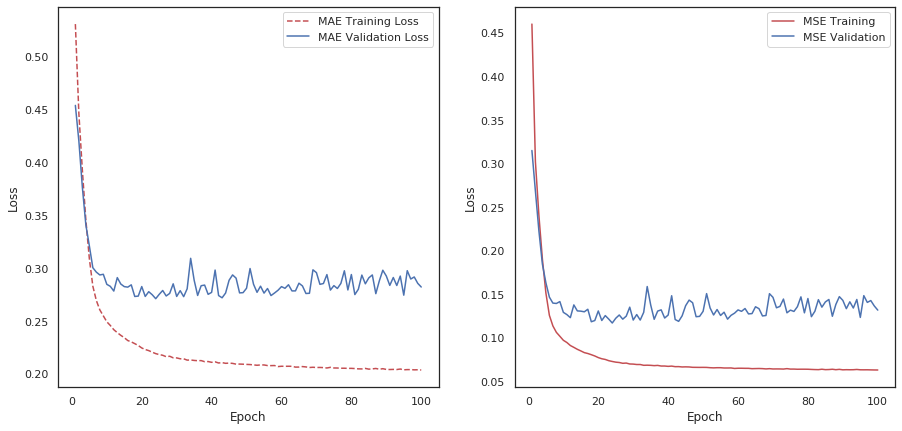

In [32]:
# Get training and test loss histories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.show();

### (Or) Read model checkpoint

In [13]:
# stop here, change file

In [19]:
# #model_filename = "training/20191218_023743.h5"

# On LTS: "training/20200221_061000.h5"
# model_filename = "training/20200220_055622.h5" local, MSE as loss, 60K training
#model_filename = "training/20200305_055207.h5" # local, MAE as loss, 60K training
#model_filename = "training/20200416_094914.h5"
#model_filename = "training/20200417_192953.h5"
#model_filename = "training/20200418_190002.h5"
#model_filename = "training/20200418_190118.h5" for symmetric
#model_filename = "training/20200422_114231.h5"

In [20]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 116, 116, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 116, 116, 1)  0           input_3[0][0]                    
____________________________________________________________________________________________

### Some model results

In [34]:
# from cryoem.distance_estimation import plot_results

In [77]:
# y_tr_pred = model.predict_on_batch([tr_pairs[:256, 0], tr_pairs[:256, 1]])
# y_val_pred = model.predict_on_batch([val_pairs[:256, 0], val_pairs[:256, 1]])

In [ ]:
# plot_train_results = plot_results(tr_pairs, y_tr_pred, tr_y, "Train")
# plot_validation_results = plot_results(val_pairs, y_val_pred, val_y, "Validation")

In [ ]:
# plot_train_results(1)

In [ ]:
# plot_validation_results(0)

---

## dP/dQ plot

In [33]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [34]:
def d_p(p1, p2):
    dist = []
    p1 = tf.cast(p1, dtype=tf.float64)
    p2 = tf.cast(p2, dtype=tf.float64)

    for i in np.arange(0, len(p1), 256):
        _p1 = p1[i:i+256, :, :]
        _p2 = p2[i:i+256, :, :]
        
        _p1 = tf.convert_to_tensor(_p1)
        _p1 = tf.expand_dims(_p1, len(_p1.shape)) 
        _p2 = tf.convert_to_tensor(_p2)
        _p2 = tf.expand_dims(_p2, len(_p2.shape))   #p2 = p2.reshape(list(p2.shape) + [-1]) 

        d = model.predict_on_batch([_p1, _p2])
        d = tf.cast(d, dtype=tf.float64)
        dist.append(d)
    
    dist = tf.concat(dist, axis=0)

    return dist

In [35]:
idx1 = list(np.random.choice(test_idx, size=1000))
idx2 = list(np.random.choice(test_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).numpy().T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

In [36]:
np.savez("data/5j0n/5j0n_DE_dPdQ_plot_full", dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

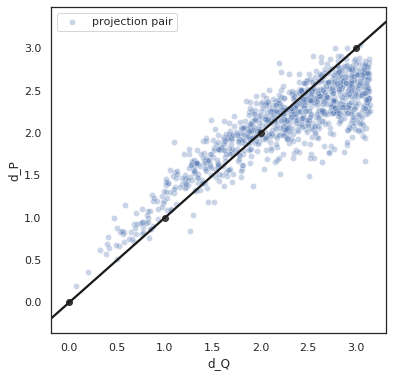

In [37]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

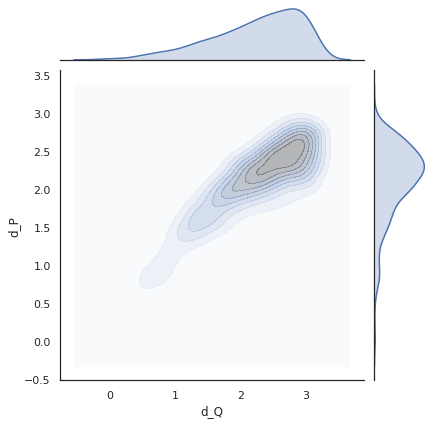

In [38]:
plot_dP_dQ_density(dP_values, dQ_values)

In [39]:
def loss(dQ_values, dP_values):
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean(tf.pow((dQ_values - dP_values), 2))

In [40]:
loss(dQ_values, dP_values).numpy()

0.13844912720232028

In [41]:
np.sqrt(1/(len(dQ_values)-1)*np.sum(np.power(dP_values-dQ_values, 2)))

0.37227370967775514

In [ ]:
# HERE

# 2. Angle Recovery

## Angle Recovery

Perfect distances. Learning rate 0.01

In [42]:
from cryoem.angle_recovery import train_angle_recovery

In [43]:
X = tf.cast(X, dtype=tf.float64)
X = X.numpy()

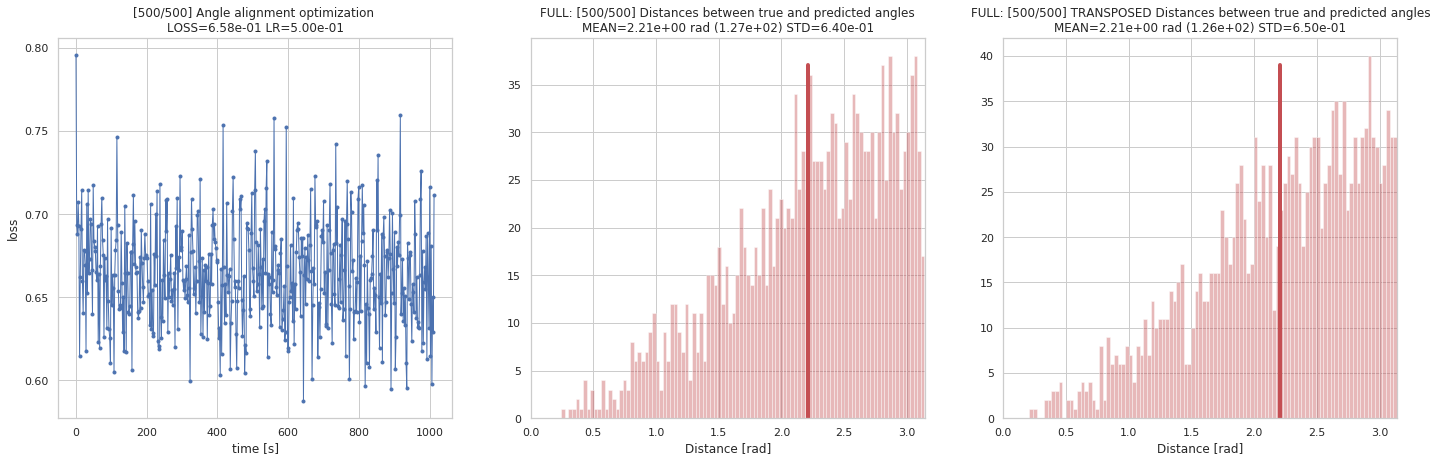

Shape of projections: (1650, 116, 116)step 50/500 (104s): loss = 6.92e-01
step 100/500 (205s): loss = 6.74e-01
step 150/500 (305s): loss = 6.60e-01
step 200/500 (406s): loss = 6.26e-01
step 250/500 (507s): loss = 7.14e-01
step 300/500 (607s): loss = 6.81e-01
step 350/500 (709s): loss = 6.34e-01
step 400/500 (811s): loss = 7.17e-01
step 450/500 (912s): loss = 6.83e-01
step 500/500 (1013s): loss = 7.11e-01



In [44]:
q_predicted2, losses2, arr2 = train_angle_recovery(steps=500, 
                                                   batch_size=512, 
                                                   in_data=X[test_idx], 
                                                   distance_fn=d_p, 
                                                   learning_rate=0.5, #0.1, 
                                                   angles_true=angles_true[test_idx],
                                                   optimization=True)

In [45]:
from scipy.spatial.transform import Rotation as R

In [51]:
angles_predicted_all = np.zeros((*arr2.shape[0:2], 3))
for i, q in enumerate(arr2):
    angles_predicted_all[i, :] = R.from_quat(q).as_euler("zyz")

In [53]:
# PREDICTED ANGLES ITERATION    
xyz = np.zeros(angles_predicted_all.shape)
for i, a in enumerate(angles_predicted_all):
    z0, y1, z1 = a[:,0], a[:,1], a[:,2]
    x = z1*np.sin(y1)*np.cos(z0)
    y = z1*np.sin(y1)*np.sin(z0)
    z = z1*np.cos(y1)
    xyz[i,:,:] = np.array([x, y, z]).T
    
# TRUE ANGLES
xyz_true = np.zeros(angles_true.shape)
z0, y1, z1 = angles_true[:,0], angles_true[:,1], angles_true[:,2]

x = z1*np.sin(y1)*np.cos(z0)
y = z1*np.sin(y1)*np.sin(z0)
z = z1*np.cos(y1)

xyz_true = np.array([x, y, z]).T

# # PREDICTED ANGLES
# xyz_predicted = np.zeros(angles_predicted.shape)
# z0, y1, z1 = angles_predicted[:,0], angles_predicted[:,1], angles_predicted[:,2]

# x = z1*np.sin(y1)*np.cos(z0)
# y = z1*np.sin(y1)*np.sin(z0)
# z = z1*np.cos(y1)

# xyz_predicted = np.array([x, y, z]).T

# Rot vector

In [60]:
arr2 = R.from_euler('zyz', angles_true[test_idx]).as_rotvec()
arr3 = np.zeros((len(angles_predicted_all), *arr2.shape))
for i, a in enumerate(angles_predicted_all):
    arr3[i,:] = R.from_euler('zyz', a).as_rotvec()

ipv.figure()
s = ipv.scatter(arr3[:, :,0], arr3[:, :,1], arr3[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(arr2[:,0], arr2[:,1], arr2[:,2], marker="sphere", color="red", size=1)
ipv.animation_control(s, interval=50)
ipv.show()

# Polar Plot

In [61]:
ipv.figure()
s = ipv.scatter(xyz[:, :,0], xyz[:, :,1], xyz[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(xyz_true[:,0], xyz_true[:,1], xyz_true[:,2], marker="sphere", color="red", size=1)
ipv.xlim(-2*np.pi, 2*np.pi);ipv.ylim(-2*np.pi, 2*np.pi);ipv.zlim(-2*np.pi, 2*np.pi);
ipv.animation_control(s, interval=50)
ipv.show()

In [ ]:
#here

In [57]:
np.save("data/5j0n/predicted_quaternions_siamese_losses_full.npy", losses2)

In [58]:
np.save("data/5j0n/predicted_quaternions_siamese_arr_full.npy", arr2)

In [59]:
q_save = np.zeros((len(q_predicted2),4))
for i, q in enumerate(q_predicted2):
    q_save[i] = q.numpy()
#q_save = q_save[test_idx]                 
np.save("data/5j0n/predicted_quaternions_siamese_full.npy", q_save)

---

# Angle Alignment

#### Prediction angles from previous phase that we want to align with true angles

In [65]:
from cryoem.conversions import quaternion2euler

In [66]:
def angles_transpose(angles):
    cols = [2, 1, 0]
    idx = np.empty_like(cols)
    idx[cols] = np.arange(len(cols))
    angles[:] = -angles[:, idx]
    return angles

In [67]:
quaternion_predicted = np.load("data/5j0n/predicted_quaternions_siamese_full.npy")

In [68]:
angles_predicted = quaternion2euler(quaternion_predicted).numpy()
np.save("data/5j0n/predicted_angles_siamese_full.npy", angles_predicted)

---

#### True angles

In [69]:
# angles_true = np.load("data/angles_true.npy")

#### Run the Optimization

The `rotation` is our minimizer and we initialize this 6D vector with random values. That is the reason the optimization sometimes converges to 0 loss and sometimes not.

In [70]:

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow_graphics.geometry.transformation import quaternion
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product
import time
from IPython import display as IPyDisplay
from scipy.spatial.transform import Rotation as R


def euler6tomarix4d(a_R):

    xy, xz, xw, yz, yw, zw = tf.unstack(a_R, axis=-1)
    
    cxy = tf.cos(xy)
    cxz = tf.cos(xz)
    cxw = tf.cos(xw)
    cyz = tf.cos(yz)
    cyw = tf.cos(yw)
    czw = tf.cos(zw)
    
    sxy = tf.sin(xy)
    sxz = tf.sin(xz)
    sxw = tf.sin(xw)
    syz = tf.sin(yz)
    syw = tf.sin(yw)
    szw = tf.sin(zw)
    
    # Note: wasn't able to create it as simple as np.ndarrays...
    Rxy = [[  cxy,  -sxy, [0.0], [0.0]], 
           [  sxy,   cxy, [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxy = tf.reshape(tf.convert_to_tensor(Rxy, dtype=tf.float64), (4, 4)) 
    
    Rxz = [[  cxz, [0.0],  -sxz, [0.0]],
           [[0.0], [1.0], [0.0], [0.0]],
           [  sxz, [0.0],   cxz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxz = tf.reshape(tf.convert_to_tensor(Rxz, dtype=tf.float64), (4, 4))
    
    Rxw = [[  cxw, [0.0], [0.0],  -sxw],
           [[0.0], [1.0], [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]], 
           [  sxw, [0.0], [0.0],  cxw]]
    Rxw = tf.reshape(tf.convert_to_tensor(Rxw, dtype=tf.float64), (4, 4))
    
    Ryz = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyz,  -syz, [0.0]],
           [[0.0],   syz,   cyz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Ryz = tf.reshape(tf.convert_to_tensor(Ryz, dtype=tf.float64), (4, 4))
    
    Ryw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyw, [0.0],  -syw],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0],   syw, [0.0],  cyw]]
    Ryw = tf.reshape(tf.convert_to_tensor(Ryw, dtype=tf.float64), (4, 4))
    
    Rzw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0], [1.0], [0.0], [0.0]], 
           [[0.0], [0.0],   czw,  -szw],
           [[0.0], [0.0],   szw,  czw]]
    Rzw = tf.reshape(tf.convert_to_tensor(Rzw, dtype=tf.float64), (4, 4))
  
    R = Rxy @ Rxz @ Rxw @ Ryz @ Ryw @ Rzw

    # check if matrix is orthogonal: R^T @ R - I < 1e-5
    assert tf.reduce_all(tf.less_equal(tf.abs(tf.subtract(tf.transpose(R) @ R, tf.eye(4, 4, dtype=tf.float64))), 1e-5)), "Matrix R (4x4) should be orthogonal!" 
        
    return R


def update_quaternion(m, a_R, q_predicted):
    # 4D matrix rotation
    R = euler6tomarix4d(a_R)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return q_predicted_rotated

def loss_alignment(m, a_R, q_predicted, q_true):
    # 4D matrix rotation
    R = euler6tomarix4d(a_R)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return tf.reduce_mean(d_q(q_true, q_predicted_rotated))


def gradient_alignment(m, a_R, q_predicted, q_true):
    with tf.GradientTape() as tape:
        loss_value = loss_alignment(m, a_R, q_predicted, q_true)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient


def training_angle_alignment(m, steps, batch_size, learning_rate, angles_true, angles_predicted):
    
    collect_data = []

    optimizer = Adam(learning_rate=learning_rate)

    time_start = time.time()

    report = ""

    losses = np.empty(steps)
    angles_predicted = tf.convert_to_tensor(angles_predicted)

    euler = tf.random.uniform([6], 0, 2*np.pi, dtype=tf.float64) #np.zeros(6, dtype=np.float64)
    a_R = [tf.Variable(euler)]

    q_predicted = euler2quaternion(angles_predicted)
    q_true = euler2quaternion(angles_true)

    for step in range(1, steps+1):

        # Sample some pairs.
        idx = list(np.random.choice(range(len(angles_predicted)), size=batch_size))

        # Compute distances between projections
        qt = [q_true[i]      for i in idx]
        qp = [q_predicted[i] for i in idx]

        # Optimize by gradient descent.
        losses[step-1], gradients = gradient_alignment(m, a_R, qp, qt)
        optimizer.apply_gradients(zip(gradients, a_R))

        update_lr = 300
        if step>update_lr and step%update_lr==0 and losses[step-1]-losses[step-1-update_lr+100] < 0.1:
            learning_rate *= 0.1

        # Visualize progress periodically
        if step % 10 == 0:
            qu = update_quaternion(m, a_R, q_predicted)

            collect_data.append(qu.numpy())

            plt.close();
            sns.set(style="white", color_codes=True)
            sns.set(style="whitegrid")

            fig, axs = plt.subplots(1, 3, figsize=(24,7))

            # Distance count subplot (batches)
            qpr = update_quaternion(m, a_R, qp)
            d1 = d_q(qpr, qt)
            axs[0].set_xlim(0, np.pi)
            #axs[0].set_ylim(0, batch_size)
            axs[0].set_title(f"BATCHES (size={len(qp)}): [{step}/{steps}] Distances between true and predicted angles \nMEAN={np.mean(d1):.2e} STD={np.std(d1):.2e}")
            s = sns.distplot(d1, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[0].plot([np.mean(d1)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

            # Optimization loss subplot
            axs[1].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
            axs[1].set_xlabel('time [s]')
            axs[1].set_ylabel('loss');
            axs[1].set_title(f"Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

            # Distance count subplot (full)
            q_predicted_rot = update_quaternion(m, a_R, q_predicted)
            d2 = d_q(q_predicted_rot, q_true)
            axs[2].set_xlim(0, np.pi)
            # axs[2].set_ylim(0, len(angles_true))
            axs[2].set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
            s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)


            IPyDisplay.clear_output(wait=True)
            IPyDisplay.display(plt.gcf())
            plt.close();
            time.sleep(.1)


        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time.time() - time_start
            report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {np.mean(losses[step-steps//10:step-1]):.2e}\n'

        if step >= 101 and np.mean(losses[step-101:step-1]) < 1e-3:
            break;

    print(report)
    print("---")
    return m, a_R, losses, np.array(collect_data)

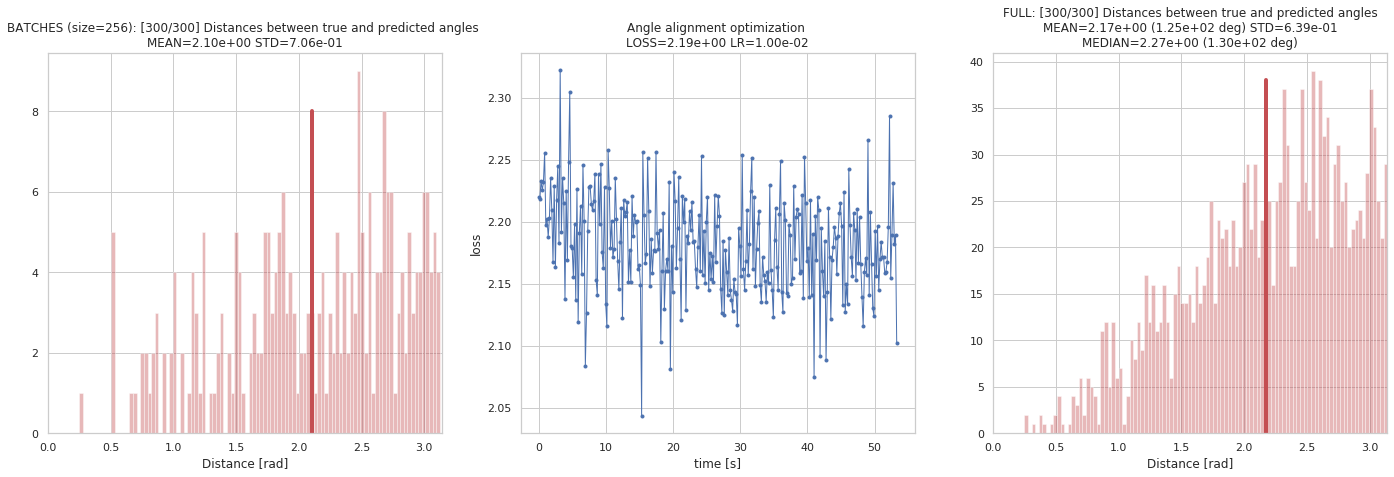

step 30/300 (5s): loss = 2.21e+00
step 60/300 (10s): loss = 2.19e+00
step 90/300 (17s): loss = 2.18e+00
step 120/300 (22s): loss = 2.18e+00
step 150/300 (27s): loss = 2.18e+00
step 180/300 (33s): loss = 2.17e+00
step 210/300 (38s): loss = 2.17e+00
step 240/300 (43s): loss = 2.18e+00
step 270/300 (49s): loss = 2.18e+00
step 300/300 (55s): loss = 2.18e+00

---


In [73]:
m, rotation, loss, collect_data  = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                                 steps=300, 
                                                 batch_size=256, 
                                                 learning_rate=0.01, 
                                                 angles_true=angles_true[test_idx], 
                                                 angles_predicted=angles_predicted)

In [74]:
m, rotation[0].numpy(), loss[-1]

([1.0, 1.0, 1.0, 1.0],
 array([5.55108418, 2.66876261, 3.81440662, 3.22843487, 5.28857892,
        2.12466674]),
 2.1021361773217215)

In [75]:
collect_data.shape

(30, 1650, 4)

In [76]:
np.max(angles_true)

6.282679945774219

In [77]:
np.max(angles_predicted)

3.1400975813589205

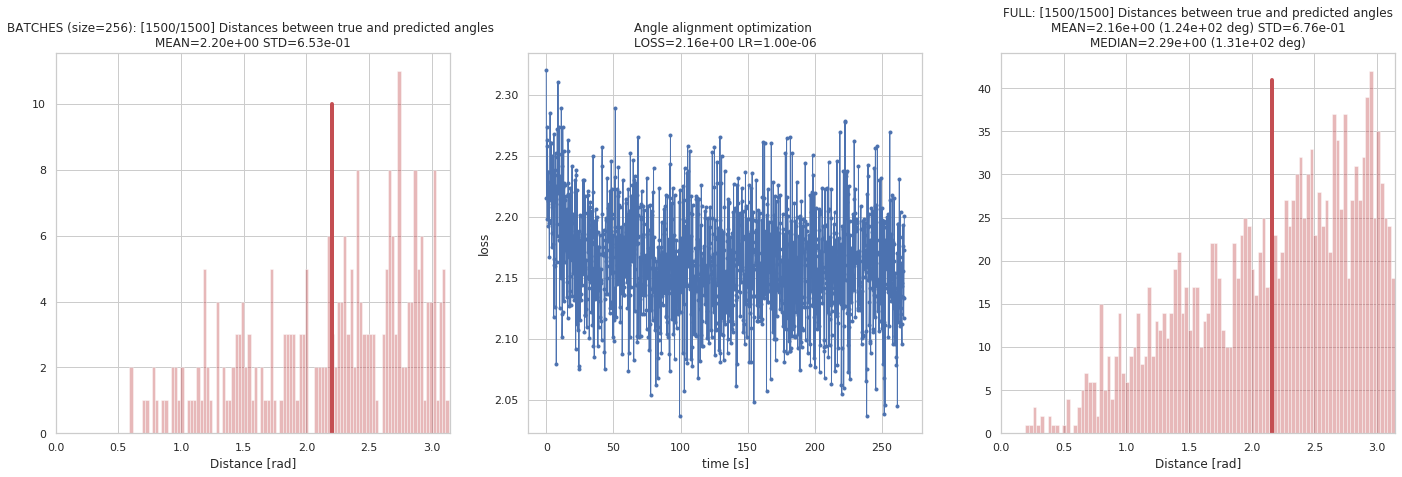

step 150/1500 (26s): loss = 2.19e+00
step 300/1500 (52s): loss = 2.17e+00
step 450/1500 (78s): loss = 2.17e+00
step 600/1500 (104s): loss = 2.16e+00
step 750/1500 (131s): loss = 2.16e+00
step 900/1500 (158s): loss = 2.16e+00
step 1050/1500 (187s): loss = 2.16e+00
step 1200/1500 (214s): loss = 2.15e+00
step 1350/1500 (241s): loss = 2.16e+00
step 1500/1500 (268s): loss = 2.15e+00

---


In [92]:
m, rotation, loss, collect_data  = training_angle_alignment(m=[-1.0, 1.0, 1.0, 1.0],
                                                 steps=1500, 
                                                 batch_size=256, 
                                                 learning_rate=0.01, 
                                                 angles_true=angles_true[test_idx], 
                                                 angles_predicted=angles_predicted)

In [96]:
m, rotation[0].numpy(), loss[-1]

([-1.0, 1.0, 1.0, 1.0],
 array([1.61025315, 3.16026295, 3.3843365 , 3.62292703, 0.74598082,
        1.27025945]),
 2.200177850486398)

# Polar Plot

In [97]:
# # PREDICTED ANGLES ITERATION
# angles_predicted_all = np.zeros((*collect_data.shape[0:2], 3))
# for i, q in enumerate(collect_data):
#     angles_predicted_all[i, :] = R.from_quat(q).as_euler("zyz")
    
# xyz = np.zeros(angles_predicted_all.shape)
# for i, a in enumerate(angles_predicted_all):
#     z0, y1, z1 = a[:,0], a[:,1], a[:,2]
#     x = z1*np.sin(y1)*np.cos(z0)
#     y = z1*np.sin(y1)*np.sin(z0)
#     z = z1*np.cos(y1)
#     xyz[i,:,:] = np.array([x, y, z]).T
    
# # TRUE ANGLES
# xyz_true = np.zeros(angles_true.shape)
# z0, y1, z1 = angles_true[:,0], angles_true[:,1], angles_true[:,2]

# x = z1*np.sin(y1)*np.cos(z0)
# y = z1*np.sin(y1)*np.sin(z0)
# z = z1*np.cos(y1)

# xyz_true = np.array([x, y, z]).T

In [98]:
angles_predicted_all = np.zeros((*collect_data.shape[0:2], 3))
for i, q in enumerate(collect_data):
    angles_predicted_all[i, :] = R.from_quat(q).as_euler("zyz")

In [99]:
# PREDICTED ANGLES ITERATION    
xyz = np.zeros(angles_predicted_all.shape)
for i, a in enumerate(angles_predicted_all):
    z0, y1, z1 = a[:,0], a[:,1], a[:,2]
    x = z1*np.sin(y1)*np.cos(z0)
    y = z1*np.sin(y1)*np.sin(z0)
    z = z1*np.cos(y1)
    xyz[i,:,:] = np.array([x, y, z]).T
    
# TRUE ANGLES
xyz_true = np.zeros(angles_true.shape)
z0, y1, z1 = angles_true[:,0], angles_true[:,1], angles_true[:,2]

x = z1*np.sin(y1)*np.cos(z0)
y = z1*np.sin(y1)*np.sin(z0)
z = z1*np.cos(y1)

xyz_true = np.array([x, y, z]).T

# PREDICTED ANGLES
xyz_predicted = np.zeros(angles_predicted.shape)
z0, y1, z1 = angles_predicted[:,0], angles_predicted[:,1], angles_predicted[:,2]

x = z1*np.sin(y1)*np.cos(z0)
y = z1*np.sin(y1)*np.sin(z0)
z = z1*np.cos(y1)

xyz_predicted = np.array([x, y, z]).T

In [103]:
ipv.figure()
s = ipv.scatter(xyz[:, :,0], xyz[:, :,1], xyz[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(xyz_true[:,0], xyz_true[:,1], xyz_true[:,2], marker="sphere", color="red", size=1)
ipv.xlim(-2*np.pi, 2*np.pi);ipv.ylim(-2*np.pi, 2*np.pi);ipv.zlim(-2*np.pi, 2*np.pi);
ipv.animation_control(s, interval=50)
ipv.show()

In [102]:
arr2 = R.from_euler('zyz', angles_true[test_idx]).as_rotvec()
arr3 = np.zeros((len(angles_predicted_all), *arr2.shape))
for i, a in enumerate(angles_predicted_all):
    arr3[i,:] = R.from_euler('zyz', a).as_rotvec()

ipv.figure()
s = ipv.scatter(arr3[:, :,0], arr3[:, :,1], arr3[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(arr2[:,0], arr2[:,1], arr2[:,2], marker="sphere", color="red", size=1)
ipv.animation_control(s, interval=50)
ipv.show()

In [104]:
qpn = euler2quaternion(angles_predicted)

qpa = update_quaternion(m=m, 
                        a_R=rotation, 
                        q_predicted=qpn)

angles_predicted_rotated = quaternion2euler(qpa).numpy()

np.save("data/5j0n/predicted_angles_siamese_full_updated.npy", angles_predicted_rotated)

In [51]:
# Image(filename='../3-reconstruction/data/5j0n_projections_and_angles_predicted_updated.png')